In [1]:
%matplotlib inline

In [110]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import patsy
import random
import sklearn.linear_model as linear
from IPython.display import HTML, display_html
import math

import sys 
sys.path.append('resources') 
import models


sns.set(style="whitegrid")

auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

## ETL <a class="anchor" id="etl"></a>


To begin, we will download to main data file using panda's fixed width reader to see what the data looks like. 

In [111]:
data = pd.read_fwf('https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt')
data.head()

,18.0,8,307.0,130.0,3504.,12.0,70,1,"""chevrolet chevelle malibu"""
0,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
1,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
2,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
3,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""
4,15.0,8,429.0,198.0,4341.0,10.0,70,1,"""ford galaxie 500"""


We observe missing column names. To fix this, we downloaded the data dictionary file onto our computer to make sense of the data. After reading through the column names, we can properly import the file with the correct header labels.

In [112]:
data = pd.read_fwf('https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt', names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name'])
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


We observe a well formatted table with labels. We have successfully loaded the data. We observe all floats and ints, with the exception of the last column which appears to be a string. According to the original research, the displacement is measured in cubic inches, the acceleration is the time in second from 0-60 mph, and the origin refers to the area of the world (1. American, 2. European, 3. Japanese).

*source: http://lib.stat.cmu.edu/datasets/cars.desc

## 1.2 - EDA <a class="anchor" id="eda"></a>


Now we will begin the EDA. We will first analyze the data as a whole, and then each individual variable.

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


We observe a total of 9 columns with 398 entries in each. One thing that stands out is the horsepower. The data dictionary states that there are missing values, which do not appear here. The data type is also an object/string, instead of the expected float. Next, we will look at a little more data than we did in the ETL.

In [114]:
print(data)

      mpg  cylinders  displacement horsepower  weight  acceleration  \
0    18.0          8         307.0      130.0  3504.0          12.0   
1    15.0          8         350.0      165.0  3693.0          11.5   
2    18.0          8         318.0      150.0  3436.0          11.0   
3    16.0          8         304.0      150.0  3433.0          12.0   
4    17.0          8         302.0      140.0  3449.0          10.5   
..    ...        ...           ...        ...     ...           ...   
393  27.0          4         140.0      86.00  2790.0          15.6   
394  44.0          4          97.0      52.00  2130.0          24.6   
395  32.0          4         135.0      84.00  2295.0          11.6   
396  28.0          4         120.0      79.00  2625.0          18.6   
397  31.0          4         119.0      82.00  2720.0          19.4   

     model_year  origin                     car_name  
0            70       1  "chevrolet chevelle malibu"  
1            70       1          "bui

We observe that the float value that is actually a float is the acceleration, while the rest of the float values all have zeroes after the decimal place. We are able to convert these values into ints if we need to later on. Since the "horsepower" column stood out, we will start our EDA there.

### Horsepower

Horsepower is an object variable, but we expected it to be a float or an int. We will first use summary statistics to get a sense of the data and see if we can spot the anomalies. 

In [115]:
data.horsepower.describe()

count       398
unique       94
top       150.0
freq         22
Name: horsepower, dtype: object

There are 94 unique entries, with the most frequent being 150. However, only 22 cars had 150 horsepower so there is plenty of variation. Now we will look at the unique values. 

In [116]:
data.horsepower.value_counts()

150.0    22
90.00    20
88.00    19
110.0    18
100.0    17
         ..
49.00     1
93.00     1
230.0     1
167.0     1
132.0     1
Name: horsepower, Length: 94, dtype: int64

We again do not observe any anomalies with the value counts, but notice that the top 5 most common cars have 150, 90, 88, 110, and 100 horsepower, in that order. Next, we will check for non-float values.

We now notice the error. There are 6 instances in which the horsepower entry has a "?" instead of a number. To move forward with the horsepower analysis, we will remove these 6 entries.

In [117]:
data['horsepower'] = data['horsepower'].apply(pd.to_numeric, errors='coerce')

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [106]:
#data.dropna(subset=['horsepower'], inplace=True)
#models code will not work with any kind of modification to horsepower data

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [120]:
data.horsepower.describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

We observe a mean of about 104 horsepower with a standard deviation of about 38.5 The lowest engine has 46 while the highest has 230. We expect most values to fall between 126 and 75, with a right skew since the mean is higher than the median. We can use a histogram to visualize the distribution.

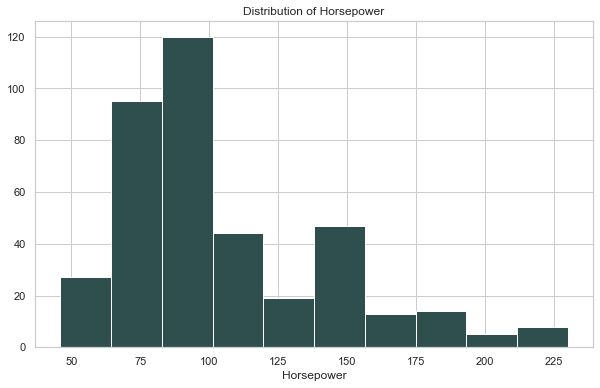

In [121]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.horsepower, color="darkslategray")
axes.set_title("Distribution of Horsepower")
axes.set_xlabel("Horsepower")

plt.show()
plt.close()

We observe that most cars have less than 150 horsepower, but there are a few that have more. Next, we will look at miles per gallon.

### MPG

Miles per gallon is a measure of the fuel economy of the car. Because of the age of the data, we expect low fuel economies from the cars.

In [15]:
data.mpg.describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

The mean fuel economy is 23.5, which is actually higher than expected. The data is not very skewed, with both the mean and median around 23.A majority of the cars have between 17.5 and 29 mpg. The most efficient car consumes about 46.6 mpg, which is impressive and actually compares to some of the hybrid cars of today. We expect the distribution to be fairly normal.

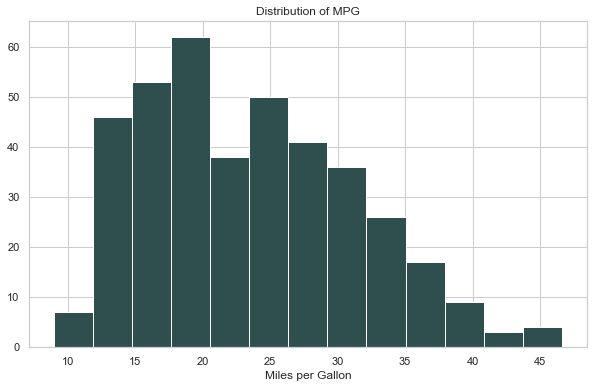

In [16]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.mpg, color="darkslategray", bins = 13)
axes.set_title("Distribution of MPG")
axes.set_xlabel("Miles per Gallon")

plt.show()
plt.close()

We observe a somewhat normally distributed chart, with a slight skew to the right. This indicates that most cars have an economy on the lower end of the chart, and there are a few outliers on the high end.

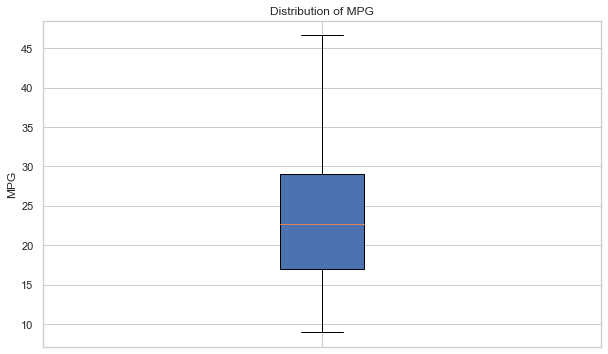

In [17]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "mpg"], labels=[""], showfliers=True, patch_artist=True, zorder=1) 
axes.set_title("Distribution of MPG") 
axes.set_ylabel("MPG")
plt.show() 
plt.close()

There is actually what seems just one outlier on the top end of the scatter plot. This plot also shows a fairly normal distribution. Next we will move on to cylinders. We expect the cars to have somewhere between 4-8 cylinders.

In [122]:
data.cylinders.value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

As expected, most cars have 4 cylinders, about half of that have 8, and the majority of the rest has 6. There are a few cars with 3 or 5 cylinders, but those are rare cases in rotary engines and the like. Let's observe this visually.

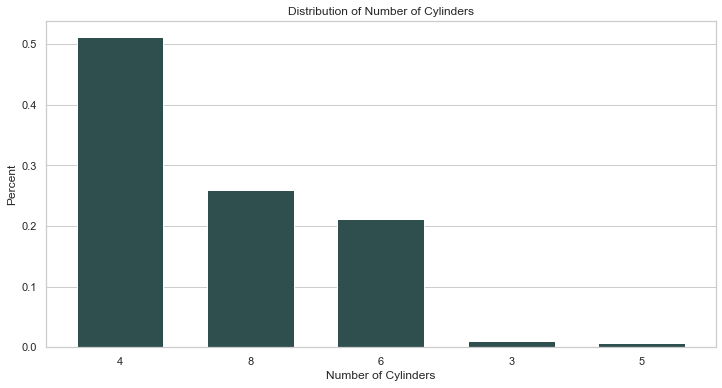

In [123]:
datac = data.cylinders.value_counts(normalize=True)
x = range(len(datac))
width = 1/1.5

figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, datac, width, align="center", color="darkslategray")
axes.set_xticks(x)
axes.set_xticklabels(datac.axes[0])
axes.set_title( "Distribution of Number of Cylinders")
axes.set_xlabel("Number of Cylinders")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

We observe that more than half of all cars in the dataset have 4 cylinders. Next, we will look at displacement. Displacement is a measure of the size of the engine. We expect this data to look similar to the horsepower.

In [124]:
data.displacement.describe()

count    398.000000
mean     193.425879
std      104.269838
min       68.000000
25%      104.250000
50%      148.500000
75%      262.000000
max      455.000000
Name: displacement, dtype: float64

We have a mean displacement of 193 cubic inches, and a median of 148.5. Clearly a right skewed distribution, with the minimum displacement being 68 and the max being 455. We will visualize this distribution. 

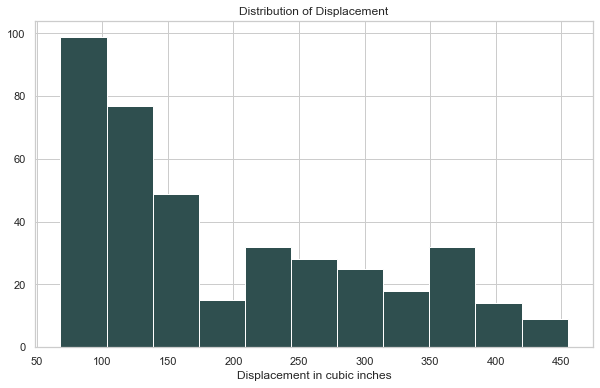

In [125]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.displacement, color="darkslategray", bins = 11)
axes.set_title("Distribution of Displacement")
axes.set_xlabel("Displacement in cubic inches")

plt.show()
plt.close()

We observe that most cars have a displacement between 50 and 150, but there are a good amount of cars above that, and their distribution is fairly uniform. Let us now move on to weight.

In [126]:
data.weight.describe()

count     398.000000
mean     2970.424623
std       846.841774
min      1613.000000
25%      2223.750000
50%      2803.500000
75%      3608.000000
max      5140.000000
Name: weight, dtype: float64

We observe the average car weighs around 3000lbs,with the lightest at only 1613 lbs and the heaviest at 5140 lbs. We have a slight right skew again. Let us visualize it.

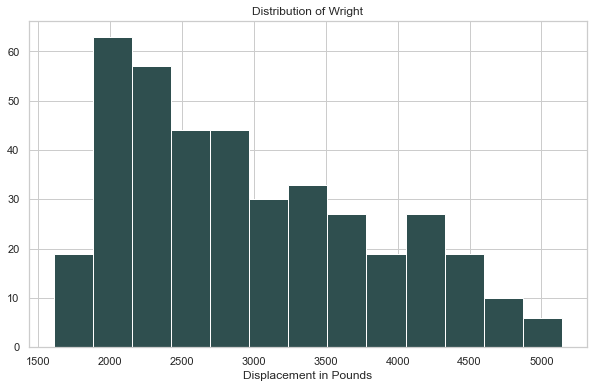

In [127]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.weight, color="darkslategray", bins = 13)
axes.set_title("Distribution of Wright")
axes.set_xlabel("Displacement in Pounds")

plt.show()
plt.close()

We observe that most of the cars weigh between 2000 and 3000 pounds, with the rest of the weight being relatively uniformly distributed. We will next analyze the acceleration.

### Acceleration

We must remember that the acceleration is measure is seconds: the less seconds, the faster the car. Therefore we expect a left skew this time, with most cars having higher numbers and a few having low numbers.

In [128]:
data.acceleration.describe()

count    398.000000
mean      15.568090
std        2.757689
min        8.000000
25%       13.825000
50%       15.500000
75%       17.175000
max       24.800000
Name: acceleration, dtype: float64

We observe a fairly unskewed distribution, with both the mean and median very close to 15.5. The fastest car reached 60 mph in 8 seconds, while the slowest too 24.8. However, most cars took between 13.825 and 17.125 seconds. We expect to see a normal distribution with the histogram.

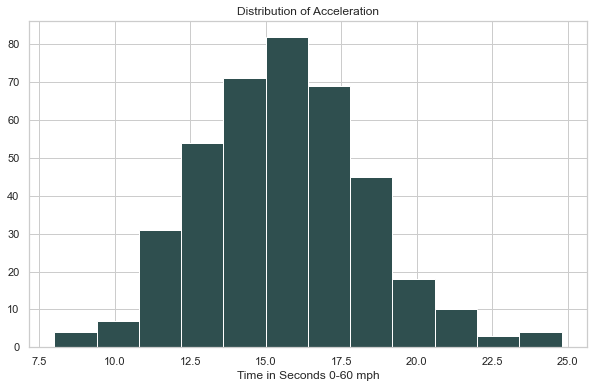

In [129]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.acceleration, color="darkslategray", bins = 12)
axes.set_title("Distribution of Acceleration")
axes.set_xlabel("Time in Seconds 0-60 mph")

plt.show()
plt.close()

As expected, we observe a beautiful normal distribution, with most cars' acceleration between 10 and 20 seconds. 

### Model Year

The model year represents the year the car was manufactured (i.e. 19__). We also expect a normal distribution here.

In [130]:
data.model_year.describe()

count    398.000000
mean      76.010050
std        3.697627
min       70.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       82.000000
Name: model_year, dtype: float64

We see that we are dealing with cars between the years of 1970 and 1982. The mean year the cars were manufactured is 1976, with most cars being made between 1973 and 1979. We will visualize this with a histogram. 

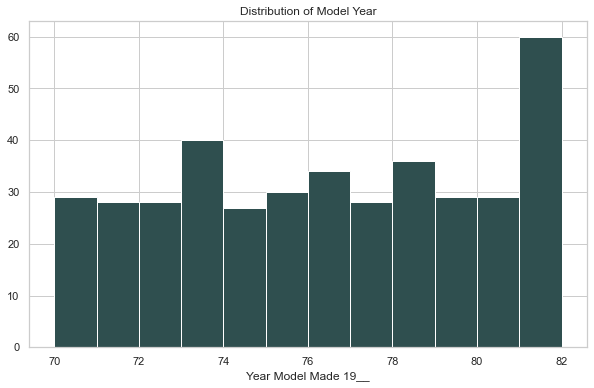

In [131]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.model_year, color="darkslategray", bins = 12)
axes.set_title("Distribution of Model Year")
axes.set_xlabel("Year Model Made 19__")

plt.show()
plt.close()

We observe a fairly uniform distribution, with a high increase in the '82 models. This may be attributed to a surge in car purchases that year. Next, we will look at origin of the car.

### Origin

We should recall the meaning of each of the int for the origin column: 

1. American
2. European
3. Japanese

Since the data was taken in th 80's, we expect a greater number of American cars than the other two categories.

In [132]:
data.origin.value_counts()

1    249
3     79
2     70
Name: origin, dtype: int64

Even further, the number of American cars is more than the other two categories put together. This is a drastic change from today. Nevertheless, we can still visualize this drastic difference.

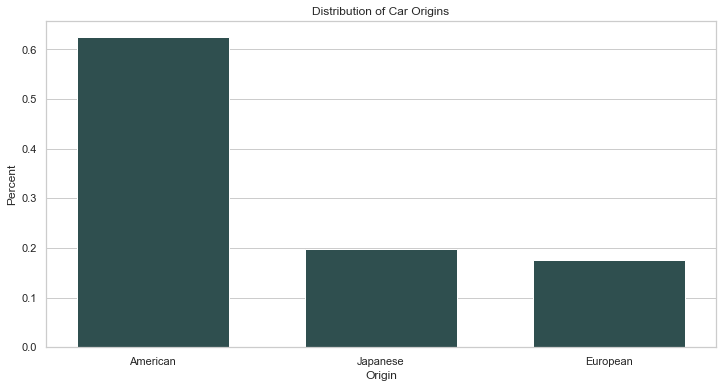

In [133]:
datao = data.origin.value_counts(normalize=True)
x = range(len(datao))
width = 1/1.5

figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, datao, width, align="center", color="darkslategray")
axes.set_xticks(x)
axes.set_xticklabels(['American', 'Japanese', 'European'])
axes.set_title( "Distribution of Car Origins")
axes.set_xlabel("Origin")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

The differences in the origins are clearly illustrated. More than 60% of the cars on list are American-made, whereas European and Japanese account for less than 20% each.

### Car Name

We will now look at car names. We expect some repeats but most of the values should be unique.

In [134]:
data.car_name.value_counts()

"ford pinto"             6
"ford maverick"          5
"amc matador"            5
"toyota corolla"         5
"amc hornet"             4
                        ..
"chevy c10"              1
"honda civic 1500 gl"    1
"renault 12 (sw)"        1
"peugeot 504 (sw)"       1
"audi 100 ls"            1
Name: car_name, Length: 305, dtype: int64

The most common cars are the Ford Pinto, AMC Matador, Toyota Corolla, Ford Maverick, and AMC Hornet. 

## Pairwise EDA

Now that we have analyzed each variable on it's own, we will do a pairwise analysis for the MPG. We will begin with the coefficients.

In [135]:
print("r   = ", stats.pearsonr(data.mpg, data.cylinders)[0])
print("rho = ", stats.spearmanr(data.mpg, data.cylinders)[0])

r   =  -0.7753962854205542
rho =  -0.8218644914450965


We observe statistically significant relationship between MPG and cylinders. It seems that the more cylinders a car has, the more fuel it will consume, which makes sense. 

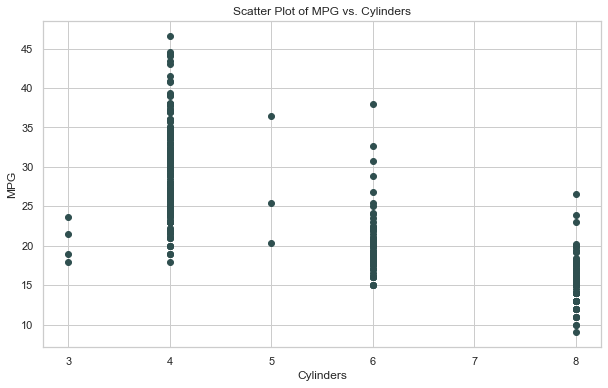

In [136]:
figure = plt.figure(figsize=(10, 6))


axes = figure.add_subplot(1, 1, 1)
axes.scatter(data.cylinders, data.mpg, marker="o", color="darkslategray")

axes.set_ylabel("MPG")
axes.set_xlabel("Cylinders")
axes.set_title("Scatter Plot of MPG vs. Cylinders")

plt.show()
plt.close()

We can observe a downward trend as the number of cylinders increases, which confirms the r values. Next, we will look at displacement, which should also have a high correlation, as bigger engines use more fuel.

In [137]:
print("r   = ", stats.pearsonr(data.mpg, data.displacement)[0])
print("rho = ", stats.spearmanr(data.mpg, data.displacement)[0])

r   =  -0.8042028248058978
rho =  -0.8556920118178749


The coefficients are even greater this time. Let us observe this graphically.

In [138]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10) 
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3) 
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6)) 

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size) 
    
    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y) 
    if not skip_lowess:
        title += " with LOWESS" 

    axes.set_title(title) 
    axes.set_xlabel(x) 
    axes.set_ylabel(y)

    plt.show() 
    plt.close()

In [139]:
def describe_by_category(data, numeric, categorical): 
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe() 
    print(grouped_y)

In [140]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    print( "r =", stats.pearsonr(data[x], data[y])[0]) 
    print( "rho =", stats.spearmanr(data[x], data[y])[0])

Displacement refers to the size of the engine. A bigger engine will yield a lower MPG because it uses more gas to run.

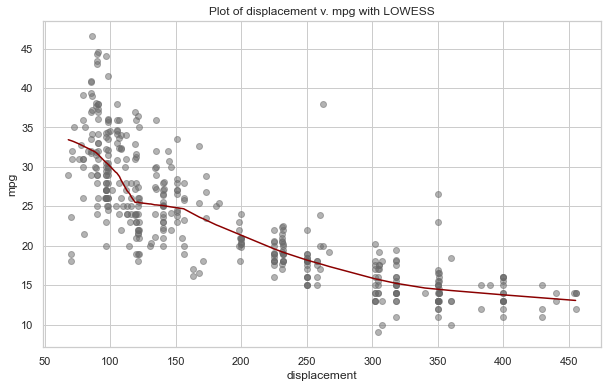

In [141]:
lowess_scatter(data, "displacement", "mpg", jitter=0.0)

Another clear decreasing trend. We will next look at weight. Theoretically, the heavier a car is, the more gas it will use to move, so we will see a negative correlation.

Correlation coefficients:
r = -0.831740933244335
rho = -0.8749473981990713


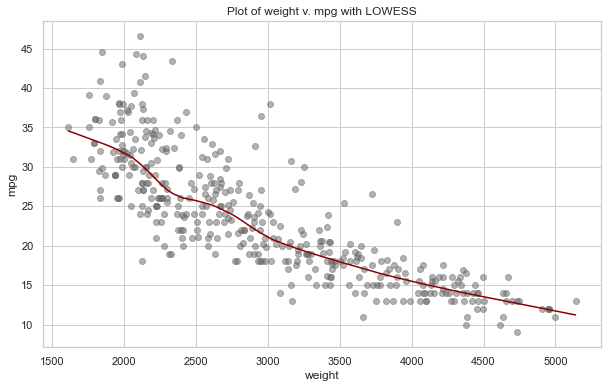

In [142]:
correlation(data, 'mpg', 'weight')
lowess_scatter(data, "weight", "mpg", jitter=0.0)

As expected, we see an almost linear correlation with the weight. We expect to see the opposite with the acceleration. The smaller (faster) acceleration will increase the MPG.

Correlation coefficients:
r = 0.4202889121016507
rho = 0.4386774795708622


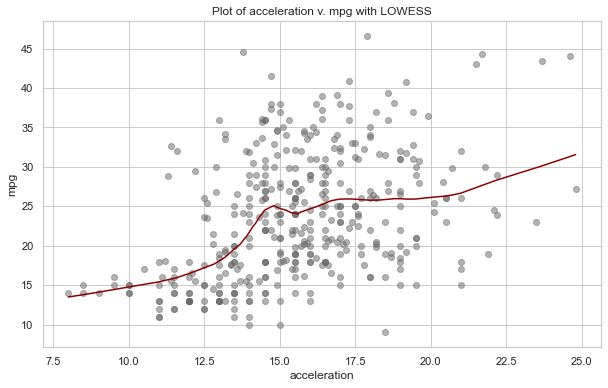

In [143]:
correlation(data, 'mpg', 'acceleration')
lowess_scatter(data, "acceleration", "mpg", jitter=0.0)

We observe the prediction, but the correlation is not as significant. Next, we will look at model year. We expect that newer cars will have better MPG.

Correlation coefficients:
r = 0.5792671330833096
rho = 0.573468703192175


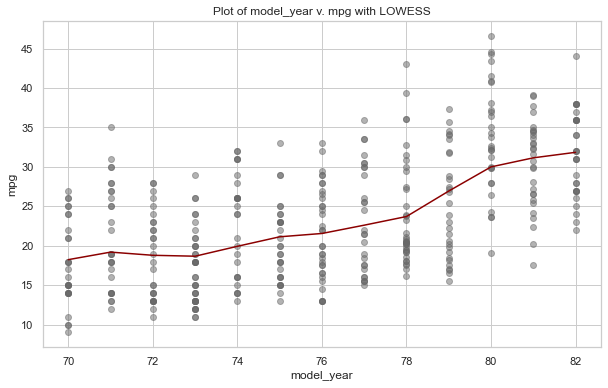

In [144]:
correlation(data, 'mpg', 'model_year')
lowess_scatter(data, "model_year", "mpg", jitter=0.0)

As expected we see an increase in MPG as the years increase, espcially after 1978. Finally, we can look at the origin of the car. We expect European and Japanese cars to be more fuel efficient. 

In [145]:
describe_by_category(data, 'mpg', 'origin')

        count       mean       std   min   25%   50%    75%   max
origin                                                           
1       249.0  20.083534  6.402892   9.0  15.0  18.5  24.00  39.0
2        70.0  27.891429  6.723930  16.2  24.0  26.5  30.65  44.3
3        79.0  30.450633  6.090048  18.0  25.7  31.6  34.05  46.6


As expected, American-made cars are between 7-10 mpg less efficient than imported cars. Finally, we have horsepower, and we expect more horsepower to mean more MPG.

## 1.3 - Build the model <a class="anchor" id="build"></a>

We will first look at all the relevant variables to build ourselves an initial model.

In [157]:
result = models.bootstrap_linear_regression("mpg ~ cylinders + displacement + horsepower + weight + acceleration + model_year", data)
models.describe_bootstrap_lr(result)

In [147]:
models.adjusted_r_squared(result)

0.8052538401408365

We observe that this model accounts for about 0.81 of the variability of the fuel economy. We also see that some of the BCIntervals cross over zero, so we will need too look into those.

Horsepower, displacement, and acceleration had unexpected signs. And since they cross over 0, we can remove them from our model, but we will keep the rest.

To build the model, we will first analyze the features for correlation to avoid multicollinearity. Since most of the features deal with the engine, we expect to see some decent correlations. First we will look at cylinders and weight. Theoretically, the bigger the engine, the bigger the weight.

In [148]:
stats.pearsonr(data.weight, data.cylinders)[0]

0.8960167954533946

The coefficient is pretty high for these two features. Lastly, we will look at weight and model year. We may expect newer cars to be lighter with advances in materials and technologies, but not too strongly.

In [149]:
stats.pearsonr(data.weight, data.model_year)[0]

-0.3065643342832897

As expected, as the cars get newer their weight decreases. Next, we will look at our model with just these features.

In [150]:
result = models.bootstrap_linear_regression("mpg ~ cylinders + weight + model_year", data)
models.describe_bootstrap_lr(result)

Our Betas are as expected, but our R squared did not improve. Let's look at the adjusted R value.

In [151]:
models.adjusted_r_squared(result)

0.8054814213036908

Minimal increase, but an increase nonetheless. Next, we will look at the residuals for each of the features.

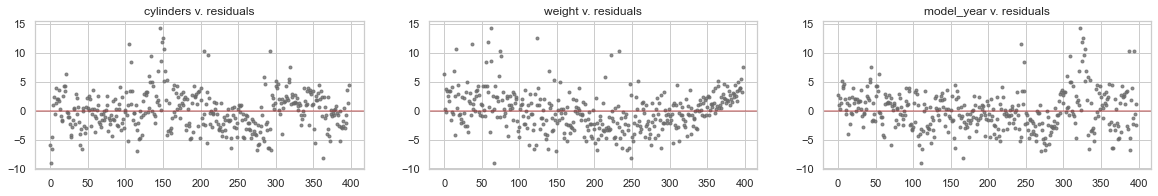

In [152]:
figure = plt.figure(figsize=(20,6))
variables = ["cylinders", "weight", "model_year"]
plots = len( variables) 
rows = (plots // 3) + 1

for i, variable in enumerate( variables): 
    axes = figure.add_subplot(rows, 3, i + 1)

    keyed_values = sorted( zip( data[ variable].values, result[ "residuals"]), key=lambda x: x[ 0])

    residuals = [x[ 1][ 0] for x in keyed_values]

    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)

    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5) 
    axes.set_title( variable + " v. residuals")
plt.show()
plt.close()

The residuals for the cylinders and model year look ok. The weight looks like there might be a bend in the data, so we will take several roots to try to get a better R^2 value.

In [153]:
data['weightadj'] = data['weight']**0.1

In [154]:
result = models.bootstrap_linear_regression("mpg ~ cylinders + weightadj + model_year", data)
models.describe_bootstrap_lr(result)

We were able to improve our R squared value and decrease our error. Let's look again at the residuals. They weight residual should have less of a bend. 

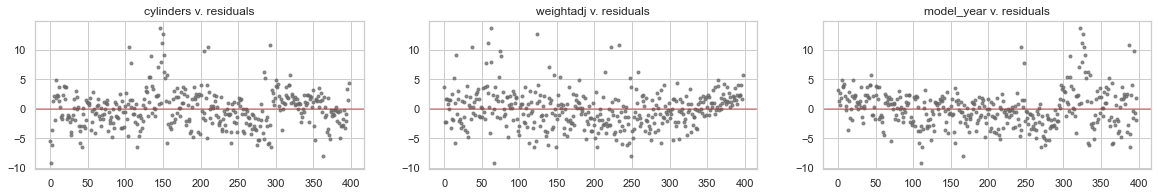

In [155]:
figure = plt.figure(figsize=(20,6))
variables = ["cylinders", "weightadj", "model_year"]
plots = len( variables) 
rows = (plots // 3) + 1

for i, variable in enumerate( variables): 
    axes = figure.add_subplot(rows, 3, i + 1)

    keyed_values = sorted( zip( data[ variable].values, result[ "residuals"]), key=lambda x: x[ 0])

    residuals = [x[ 1][ 0] for x in keyed_values]

    axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)

    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5) 
    axes.set_title( variable + " v. residuals")
plt.show()
plt.close()

The residuals look better and thus, we can continue. 

## 1.4 - Describe the model <a class="anchor" id="describe"></a>

In [156]:
predictions = {"cylinders": "-", "weightadj": "-", "model_year": "+", }
models.evaluate_coefficient_predictions(predictions, result)

cylinders P(<0)=0.250 (weak)
weightadj P(<0)=1.000 (strong)
model_year P(>0)=1.000 (strong)


All of the features will be influencing the mpg differently, even though they're all fairly well correlated with it. To begin with we expected the sign of cylinders to be negative. The more cylinders a car has, the more gas it will use.

Next we looked at displacement. The displacement describes the size of the engine. While a bigger engine will make a car go fast, it will not aid in fuel economy. Thus the sign will be negative. However, the sign and confidence interval did not support this as a certainty, so we decided not to include it in our model.

The weight of the car will cause the car to use more gasoline to get started. Therefore, the will also be a negative correlation here, with heavier cars using more gas.

Acceleration, measured in speed to 60 mph, will also be inversely related to fuel efficiency. Faster cars are not known for being fuel-friendly, and the faster a car reaches 60 mph, the more fuel it will use. This also proved unconvincingly contrary to the data, maybe the cars that accelerated faster also had better engines that were more economical when not accelerating quickly.

A positive correlation is the model year. Older cars are expected to have worse fuel economies than newer ones, as engines become more efficient and laws are put into place for environmental concerns. 

## 1.5 - Use the model <a class="anchor" id="use"></a>

We can use our model to predict how fuel efficient a car would be. We can pick a car from 1970, that has 4 cylinders and weighs about 3000 lbs. The older year and higher weight should give this car a fuel economy on the lower end.

In [82]:
predicted = result["model"].predict(np.array([[1, 4, 3000**0.1, 70]]))[0][0] 
predicted

17.6599527526228

Such a car would have a fuel economy of about 18 MPG. We can find our 95% BCI from this.

In [83]:
print("({0:.2f}, {1:.2f})".format(predicted - 2 * result["sigma"], predicted + 2 * result["sigma"]))

(11.30, 24.02)


Thus, we have a 95% confidence that the MPG will be between 11 and 24. We can also figure out the bootstrap. We expect an MPG very close to 17.6.

In [84]:
def bootstrap_prediction(result, feature_values):
    results = []
    for coefficients in result["resampled_coefficients"].itertuples():
        estimate = 0
        for feature in feature_values.keys():
            estimate += feature_values[feature] * getattr(coefficients, feature) 
        results.append(estimate)
    return np.array(results)

In [86]:
feature_values = {"intercept": 1, "cylinders": 4, "weightadj": 3000**0.1, "model_year": 70} 
posterior_prediction = bootstrap_prediction(result, feature_values) 
posterior_prediction.mean()

17.62542280454472

In [87]:
print("95% BCI", stats.mstats.mquantiles( posterior_prediction, [0.025, 0.975]))

95% BCI [16.67004325 18.71722566]


As expected, our bootstrap prediction was 17.6, with a very tight confidence interval. The distribution also looks fairly normal.  

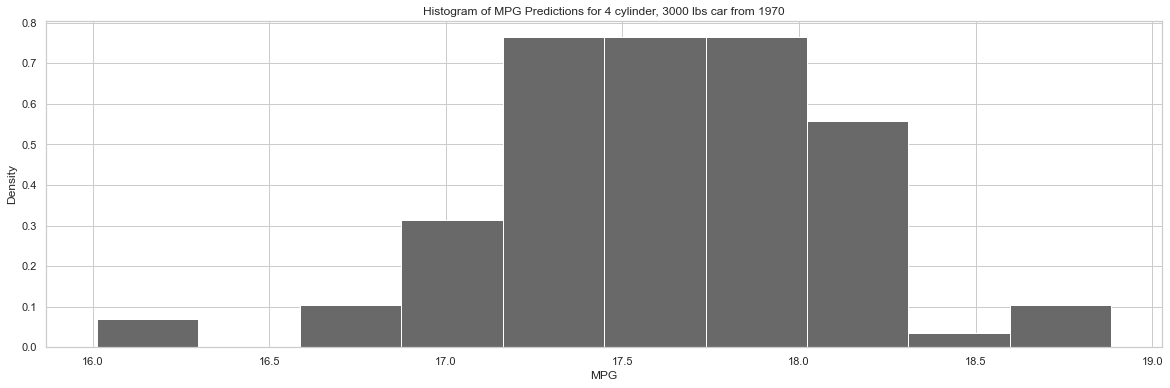

In [88]:
figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(posterior_prediction, color="DimGray", density=True)
axes.set_xlabel( "MPG")
axes.set_ylabel( "Density")
axes.set_title("Histogram of MPG Predictions for 4 cylinder, 3000 lbs car from 1970")
plt.show() 
plt.close()